## Setup and Data Loading

This cell imports all necessary libraries and the data artifacts (like `TEXT`, `LABEL`, and raw data) from the `data_pipeline.py` module.

To prepare the data for the RNN, this cell defines two key components:
* **`TRECDataset`:** A custom PyTorch `Dataset` class that takes the raw data and converts the text tokens (strings) into numerical IDs (tensors) using the `TEXT.vocab`.
* **`collate_batch`:** A function that gathers individual examples into a batch. It pads all text sequences to be the same length and, most importantly, **sorts the sequences within the batch by length (descending)**. This sorting is required for using `pack_padded_sequence` in the RNN model, which allows it to efficiently process variable-length sequences.

Finally, it creates the `train_loader`, `valid_loader`, and `test_loader` with a **`BATCH_SIZE` of 64**.

In [ ]:
# Setup and Data Loading 

# Import data pipeline and base libraries
from data_pipeline import (
    TEXT, LABEL,
    train_dataset as train_data_raw, 
    valid_dataset as valid_data_raw, 
    test_data as test_data_raw,     
    create_embedding_layer,
    device
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import numpy as np
import time
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Define Constants
VOCAB_SIZE = len(TEXT.vocab)
EMBED_DIM = TEXT.vocab.vectors.shape[1]
NUM_CLASSES = len(LABEL.vocab)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# Get the pre-trained embedding matrix from the vocab
pretrained_embeddings = TEXT.vocab.vectors

# Get the string-to-index maps from the vocab
word2idx = TEXT.vocab.stoi
label2idx = LABEL.vocab.stoi

# Create PyTorch Datasets and DataLoaders

class TRECDataset(Dataset):
    def __init__(self, torchtext_dataset, word2idx, label2idx):
        self.examples = torchtext_dataset.examples
        self.word2idx = word2idx
        self.label2idx = label2idx

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        tokens = example.text  # This is a list of strings
        
        # Convert tokens to numerical IDs
        token_ids = [self.word2idx.get(token, UNK_IDX) for token in tokens]
        
        label_id = self.label2idx[example.label]
        
        return {
            'text': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label_id, dtype=torch.long),
            'length': len(token_ids) # Return the original length
        }

def collate_batch(batch):
    # batch is a list of dicts: [{'text': t, 'label': l, 'length': len}, ...]
    
    labels_list = [item['label'] for item in batch]
    texts_list = [item['text'] for item in batch]
    lengths_list = [item['length'] for item in batch]

    # Pad the text sequences
    texts_padded = pad_sequence(texts_list, batch_first=True, padding_value=PAD_IDX)
    
    labels = torch.stack(labels_list)
    lengths = torch.tensor(lengths_list, dtype=torch.long)

    # Sort by length (descending) for packing (required by RNN)
    lengths, sort_idx = lengths.sort(dim=0, descending=True)
    texts_padded = texts_padded[sort_idx]
    labels = labels[sort_idx]
    
    # Return the tuple expected by the train/evaluate functions
    return texts_padded, labels, lengths

# Define Dataloaders 
BATCH_SIZE = 64

# Pass the maps to the dataset constructor
train_dataset = TRECDataset(train_data_raw, word2idx, label2idx)
valid_dataset = TRECDataset(valid_data_raw, word2idx, label2idx)
test_dataset = TRECDataset(test_data_raw, word2idx, label2idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Device: {device}")
print(f"Vocab Size: {VOCAB_SIZE}")
print(f"Embedding Dim: {EMBED_DIM}")
print(f"Num Classes: {NUM_CLASSES}")
print(f"Batch Size: {BATCH_SIZE}")

Device: cpu
Vocab Size: 7432
Embedding Dim: 300
Num Classes: 6
Batch Size: 64


# 2. Model and Helper Functions

This section defines the core components for the RNN experiments.

* **`SimpleRNN` Class:** This is the baseline RNN model. It uses an `nn.Embedding` layer loaded with pre-trained GloVe vectors and a single-layer `nn.RNN`. It efficiently handles padding by using `pack_padded_sequence`. A `pooling_method` argument is included to test different sentence representation strategies (e.g., 'last', 'max', 'mean') as required by **Q2(d)**.

* **Helper Functions:**
    * **`train_model`:** This function handles a single training epoch. It iterates through the data, performs the forward/backward pass, and updates the model weights.
    * **`evaluate_model`:** This function evaluates the model on the validation or test set. It runs in `eval()` mode with `torch.no_grad()` and returns the average loss, accuracy, and a list of all predictions for later analysis.

In [ ]:
# Model Definition 

# Define a single, consolidated RNN Model 
# This model now handles "last", "max", and "mean" pooling

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 n_layers, dropout, pad_idx, pooling_method='last'):
        
        super().__init__()
        
        # Use the helper function to create the embedding layer
        self.embedding = create_embedding_layer(freeze=False) 
        
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=False, 
            dropout=dropout if n_layers > 1 else 0,  # Dropout only between RNN layers
            batch_first=True 
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout_layer = nn.Dropout(dropout) # Regularization dropout
        self.pooling_method = pooling_method

    def forward(self, text, lengths):
        # text = [batch_size, seq_len]
        # lengths = [batch_size]

        embedded = self.embedding(text)
        # embedded = [batch_size, seq_len, embed_dim]

        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, lengths.to('cpu'), batch_first=True)
        
        # RNN forward pass
        packed_output, hidden = self.rnn(packed_embedded)

        
        if self.pooling_method == 'max':
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
            pooled = F.max_pool1d(output.permute(0, 2, 1), output.shape[1]).squeeze(2)
            
        elif self.pooling_method == 'mean':
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
            pooled = torch.mean(output, dim=1)

        else: # (Global Pooling)
            # Use the hidden state from the last layer
            pooled = hidden.squeeze(0) 

        # -------------------------------------
        
        dropped = self.dropout_layer(pooled)
        prediction = self.fc(dropped)
        
        return prediction

In [ ]:
# Helper Functions (Train & Evaluate)

# Define a single, consolidated training function
def train_model(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Set model to training mode
    
    for text, labels, lengths in loader:
        text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds_class = predictions.argmax(dim=1)
        acc = accuracy_score(labels.cpu(), preds_class.cpu())
        
        epoch_loss += loss.item()
        epoch_acc += acc
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Define a single, consolidated evaluation function
def evaluate_model(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    all_preds = []
    all_labels = []
    
    model.eval() # Set model to evaluation mode
    
    with torch.no_grad():
        for text, labels, lengths in loader:
            text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)

            predictions = model(text, lengths)
            loss = criterion(predictions, labels)

            preds_class = predictions.argmax(dim=1)
            
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            epoch_loss += loss.item()
            
    avg_loss = epoch_loss / len(loader)
    avg_acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, avg_acc, all_labels, all_preds

# 3. Experiment 1: Pooling Method Comparison (Q2d)

This cell conducts the experiment required for **Q2(d)**, comparing different sentence representation methods.

* It defines three `SimpleRNN` models, all without regularization (`DROPOUT = 0.0`), each using a different `pooling_method`:
    1.  **Global Pooling (Last Hidden)**
    2.  **Max Pooling**
    3.  **Mean Pooling**
* It then trains each of these three models for 10 epochs, tracking their **validation accuracy** to find the best-performing model state.
* After training, it loads the best saved state for each model and evaluates it on the **test set** to get the final, reportable accuracy scores.
* Finally, it prints a summary table of the validation and test accuracies and saves the name of the winning strategy (based on validation) in the `best_pooling_method` variable for the next experiment.

In [ ]:
# Experiment - Pooling Method Comparison
print("--- Experiment 1: Comparing Pooling Methods (Q2d) ---")

# Define Hyperparameters
HIDDEN_DIM = 256
NUM_LAYERS = 1
DROPOUT = 0.0     # Start with no regularization
LEARNING_RATE = 0.001
N_EPOCHS = 10

# Define models for the experiment
rnn_last_pooling = SimpleRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=NUM_CLASSES,
    n_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX,
    pooling_method='last' #
).to(device)

rnn_max_pooling = SimpleRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=NUM_CLASSES,
    n_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX,
    pooling_method='max' #
).to(device)

rnn_mean_pooling = SimpleRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=NUM_CLASSES,
    n_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX,
    pooling_method='mean' #
).to(device)

# Train all models
models_to_test = {
    "Global Pooling (Last Hidden)": rnn_last_pooling,
    "Max Pooling": rnn_max_pooling,
    "Mean Pooling": rnn_mean_pooling
}

pooling_results = {}
criterion = nn.CrossEntropyLoss()

for name, model in models_to_test.items():
    print(f"\nTraining model: {name}...")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 
    best_valid_acc = -1
    best_model_state = None 
    
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc, _, _ = evaluate_model(model, valid_loader, criterion)
        
        # Save the model state if it has the best validation accuracy so far
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_state = model.state_dict().copy() #
            
        print(f'Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    # Store the best validation accuracy and state for comparison
    pooling_results[name] = {
        "best_valid_acc": best_valid_acc,
        "model_state": best_model_state
    }

# Report pooling results on both Validation and Test sets
print("\n--- Q2(d) Pooling Results ---")
best_pooling_name = ""
best_pooling_acc = -1
results_for_report = []

for name, result_data in pooling_results.items():
    current_valid_acc = result_data['best_valid_acc']
    model_state = result_data['model_state']
    
    # Determine pooling method string from name
    if "Max" in name:
        method = 'max'
    elif "Mean" in name:
        method = 'mean'
    else:
        method = 'last'
    
    # Create a fresh model instance to load the best state
    eval_model = SimpleRNN(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=NUM_CLASSES,
        n_layers=NUM_LAYERS,
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        pooling_method=method
    ).to(device)
    
    eval_model.load_state_dict(model_state)
    
    # Evaluate on the TEST set
    test_loss, test_acc, _, _ = evaluate_model(eval_model, test_loader, criterion)
    
    results_for_report.append({
        "Strategy": name,
        "Validation Accuracy": current_valid_acc * 100,
        "Test Accuracy": test_acc * 100
    })
    
    # Still determine the best model based on VALIDATION accuracy
    if current_valid_acc > best_pooling_acc:
        best_pooling_acc = current_valid_acc
        best_pooling_name = name

# Print the results table
print("Accuracy Scores for Q2(d) Report:")
print(f"{'Strategy':<30} | {'Validation Acc':<18} | {'Test Acc':<10}")
print("-" * 64)
for res in results_for_report:
    print(f"{res['Strategy']:<30} | {res['Validation Accuracy']:<18.2f}% | {res['Test Accuracy']:<10.2f}%")

# Determine the internal name ('last', 'max', or 'mean') for the best method
if "Max" in best_pooling_name:
    best_pooling_method = 'max'
elif "Mean" in best_pooling_name:
    best_pooling_method = 'mean'
else:
    best_pooling_method = 'last'

print(f"\n-> Best Pooling Method (based on validation): {best_pooling_name} (internal name: '{best_pooling_method}')")

--- Experiment 1: Comparing Pooling Methods (Q2d) ---

Training model: Global Pooling (Last Hidden)...
Epoch 01/10 | Train Loss: 1.318 | Train Acc: 46.99% | Val. Loss: 1.201 | Val. Acc: 51.10%
Epoch 02/10 | Train Loss: 0.825 | Train Acc: 70.73% | Val. Loss: 0.910 | Val. Acc: 66.61%
Epoch 03/10 | Train Loss: 0.604 | Train Acc: 79.41% | Val. Loss: 0.781 | Val. Acc: 74.95%
Epoch 04/10 | Train Loss: 0.440 | Train Acc: 85.48% | Val. Loss: 1.167 | Val. Acc: 59.91%
Epoch 05/10 | Train Loss: 0.264 | Train Acc: 91.93% | Val. Loss: 0.753 | Val. Acc: 74.22%
Epoch 06/10 | Train Loss: 0.178 | Train Acc: 94.84% | Val. Loss: 0.974 | Val. Acc: 68.35%
Epoch 07/10 | Train Loss: 0.091 | Train Acc: 97.53% | Val. Loss: 1.034 | Val. Acc: 69.27%
Epoch 08/10 | Train Loss: 0.428 | Train Acc: 85.60% | Val. Loss: 1.399 | Val. Acc: 55.69%
Epoch 09/10 | Train Loss: 0.358 | Train Acc: 87.37% | Val. Loss: 2.023 | Val. Acc: 47.25%
Epoch 10/10 | Train Loss: 0.123 | Train Acc: 96.46% | Val. Loss: 2.013 | Val. Acc: 53.7

# 4. Experiment 2: Regularization Comparison (Q2b)

This cell conducts the experiment for **Q2(b)**, comparing different regularization strategies to find the best one.

* It uses the `best_pooling_method` (e.g., 'mean') determined from the previous experiment.
* It defines four distinct configurations to test:
    1.  **Baseline:** No regularization (`dropout=0.0`, `weight_decay=0.0`).
    2.  **Dropout:** `dropout=0.5` only.
    3.  **L2 Regularization:** `weight_decay=1e-4` only.
    4.  **Dropout + L2:** A combination of both.
* The code iterates through these configurations, training a separate RNN for each one. It saves the model state that achieves the highest **validation accuracy**.
* After training all models, it loads the best state for each strategy and evaluates them on the **test set** to get the final test accuracies for the report.
* It prints a summary table comparing both validation and test scores and saves the details of the best strategy (based on validation) in the `best_reg_name` variable.

In [ ]:
# Experiment - Regularization Comparison 
print("\n--- Experiment 2: Comparing Regularization (Q2b) ---")

# Define configurations for the experiment
# We use the best pooling method from the previous step
regularization_configs = [
    {
        "name": "Baseline (No Regularization)",
        "dropout": 0.0,
        "weight_decay": 0.0
    },
    {
        "name": "Dropout (0.5)",
        "dropout": 0.5,
        "weight_decay": 0.0
    },
    {
        "name": "L2 Regularization (1e-4)",
        "dropout": 0.0,
        "weight_decay": 1e-4  
    },
    {
        "name": "Dropout + L2",
        "dropout": 0.5,
        "weight_decay": 1e-4
    }
]

# Train a model for each configuration
regularization_results = {}
criterion = nn.CrossEntropyLoss()

for config in regularization_configs:
    name = config["name"]
    print(f"\nTraining model: {name}...")
    
    # Define the model with the specified dropout
    model = SimpleRNN(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=NUM_CLASSES,
        n_layers=NUM_LAYERS,
        dropout=config["dropout"], # Set dropout from config
        pad_idx=PAD_IDX,
        pooling_method=best_pooling_method
    ).to(device)
    
    # Define optimizer with specified L2 (weight_decay)
    optimizer = optim.Adam(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=config["weight_decay"] # Set L2 from config
    )
    
    best_valid_acc = -1
    best_model_state = None 
    
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc, _, _ = evaluate_model(model, valid_loader, criterion)
        
        # Save the model state if it has the best validation accuracy so far
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_state = model.state_dict().copy() #
            
        print(f'Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    # Store config, best val acc, and the best model state
    regularization_results[name] = {
        "best_valid_acc": best_valid_acc,
        "config": config,
        "model_state": best_model_state #
    }


# Report regularization results on both Validation and Test sets
print("\n--- Q2(b) Regularization Results ---")
best_reg_name = ""
best_reg_acc = -1
results_for_report = []

for name, result_data in regularization_results.items():
    current_valid_acc = result_data['best_valid_acc']
    model_state = result_data['model_state']
    config = result_data['config']

    # Create a fresh model instance
    eval_model = SimpleRNN(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=NUM_CLASSES,
        n_layers=NUM_LAYERS,
        dropout=config['dropout'],
        pad_idx=PAD_IDX,
        pooling_method=best_pooling_method
    ).to(device)
    
    eval_model.load_state_dict(model_state)
    
    # Evaluate on the TEST set
    test_loss, test_acc, _, _ = evaluate_model(eval_model, test_loader, criterion)
    
    results_for_report.append({
        "Strategy": name,
        "Validation Accuracy": current_valid_acc * 100,
        "Test Accuracy": test_acc * 100
    })
    
    # Find best model based on VALIDATION accuracy
    if current_valid_acc > best_reg_acc:
        best_reg_acc = current_valid_acc
        best_reg_name = name


print("Accuracy Scores for Q2(b) Report:")
print(f"{'Strategy':<30} | {'Validation Acc':<18} | {'Test Acc':<10}")
print("-" * 64)
results_for_report.sort(key=lambda x: x['Test Accuracy'], reverse=True)
for res in results_for_report:
    print(f"{res['Strategy']:<30} | {res['Validation Accuracy']:<18.2f}% | {res['Test Accuracy']:<10.2f}%")

print(f"\n-> Best Regularization Strategy (based on validation): {best_reg_name}")


--- Experiment 2: Comparing Regularization (Q2b) ---

Training model: Baseline (No Regularization)...
Epoch 01/10 | Train Loss: 1.294 | Train Acc: 51.85% | Val. Loss: 0.904 | Val. Acc: 69.82%
Epoch 02/10 | Train Loss: 0.837 | Train Acc: 72.98% | Val. Loss: 0.792 | Val. Acc: 73.39%
Epoch 03/10 | Train Loss: 0.586 | Train Acc: 82.77% | Val. Loss: 0.671 | Val. Acc: 77.89%
Epoch 04/10 | Train Loss: 0.469 | Train Acc: 86.50% | Val. Loss: 0.546 | Val. Acc: 81.47%
Epoch 05/10 | Train Loss: 0.364 | Train Acc: 90.11% | Val. Loss: 0.728 | Val. Acc: 77.16%
Epoch 06/10 | Train Loss: 0.281 | Train Acc: 92.72% | Val. Loss: 0.568 | Val. Acc: 83.03%
Epoch 07/10 | Train Loss: 0.207 | Train Acc: 94.95% | Val. Loss: 0.828 | Val. Acc: 77.89%
Epoch 08/10 | Train Loss: 0.213 | Train Acc: 94.57% | Val. Loss: 0.973 | Val. Acc: 80.64%
Epoch 09/10 | Train Loss: 0.122 | Train Acc: 97.19% | Val. Loss: 0.639 | Val. Acc: 82.75%
Epoch 10/10 | Train Loss: 0.091 | Train Acc: 98.08% | Val. Loss: 0.719 | Val. Acc: 82.4

# 5. Final Model Training and Evaluation (Q2c & Q2e)

These cells conclude the experiment for Part 2.

* **Final Model Training:** The first cell selects the optimal configuration (pooling strategy and regularization strategy) based on the **best validation accuracy** from the experiments above. It then trains this final "best" model for 10 epochs, saving the model state with the lowest validation loss to `best_rnn_model.pt`.

* **Plotting (Q2c):** As required by **Q2(c)**, this cell also generates and displays the "Training vs. Validation Loss" and "Training vs. Validation Accuracy" curves for this best model, saving the plot to `rnn_best_model_curves.png`.

* **Final Evaluation (Q2e):** The second cell loads the `best_rnn_model.pt` file and evaluates this model on the **test set**. It prints the final test accuracy and the detailed, topic-wise classification report (including precision, recall, and F1-score) as required by **Q2(e)**.


--- Training Final 'Best' Model (Q2c) ---
Using Best Config: Baseline (No Regularization)
Training best model (Pooling=mean, Dropout=0.0, L2=0.0) for 10 epochs...
Epoch 01/10 | Train Loss: 1.345 | Train Acc: 48.51% | Val. Loss: 0.944 | Val. Acc: 70.64%
Epoch 02/10 | Train Loss: 0.784 | Train Acc: 75.79% | Val. Loss: 0.727 | Val. Acc: 75.23%
Epoch 03/10 | Train Loss: 0.622 | Train Acc: 81.63% | Val. Loss: 0.643 | Val. Acc: 79.45%
Epoch 04/10 | Train Loss: 0.446 | Train Acc: 87.64% | Val. Loss: 0.635 | Val. Acc: 79.72%
Epoch 05/10 | Train Loss: 0.371 | Train Acc: 90.07% | Val. Loss: 0.910 | Val. Acc: 75.32%
Epoch 06/10 | Train Loss: 0.296 | Train Acc: 92.93% | Val. Loss: 0.631 | Val. Acc: 81.65%
Epoch 07/10 | Train Loss: 0.215 | Train Acc: 95.29% | Val. Loss: 0.624 | Val. Acc: 81.74%
Epoch 08/10 | Train Loss: 0.211 | Train Acc: 95.95% | Val. Loss: 1.702 | Val. Acc: 64.22%
Epoch 09/10 | Train Loss: 0.380 | Train Acc: 88.77% | Val. Loss: 0.812 | Val. Acc: 77.16%
Epoch 10/10 | Train Loss: 

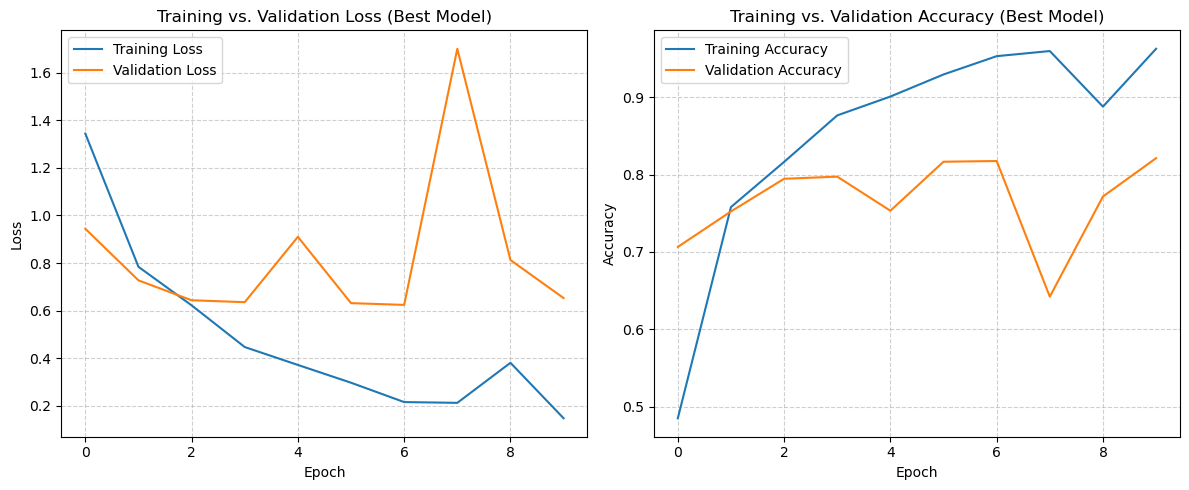

In [ ]:
# Final Model Training & Plotting
print("\n--- Training Final 'Best' Model (Q2c) ---")

# Get the best config from the regularization experiment
best_config_name = max(regularization_results, key=lambda k: regularization_results[k]['best_valid_acc'])
best_config = regularization_results[best_config_name]['config']

print(f"Using Best Config: {best_config_name}")

# Define final model based on best experimental config
FINAL_HIDDEN_DIM = 256
FINAL_NUM_LAYERS = 1
FINAL_DROPOUT = best_config['dropout']
FINAL_WEIGHT_DECAY = best_config['weight_decay']
FINAL_LR = 0.001
FINAL_POOLING = best_pooling_method
FINAL_EPOCHS = 10 

best_model = SimpleRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=NUM_CLASSES,
    n_layers=FINAL_NUM_LAYERS,
    dropout=FINAL_DROPOUT,
    pad_idx=PAD_IDX,
    pooling_method=FINAL_POOLING
).to(device)

optimizer = optim.Adam(
    best_model.parameters(), 
    lr=FINAL_LR, 
    weight_decay=FINAL_WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss()

# Train final model and store history for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_valid_loss = float('inf')

print(f"Training best model (Pooling={FINAL_POOLING}, Dropout={FINAL_DROPOUT}, L2={FINAL_WEIGHT_DECAY}) for {FINAL_EPOCHS} epochs...")

for epoch in range(FINAL_EPOCHS):
    train_loss, train_acc = train_model(best_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, _, _ = evaluate_model(best_model, valid_loader, criterion)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)
    
    # Save the best model based on validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(best_model.state_dict(), 'best_rnn_model.pt')
        
    print(f'Epoch {epoch+1:02}/{FINAL_EPOCHS} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

print("Final model training complete.")

# Plot Training Loss and Validation Accuracy Curves [cite: 448-450]
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('rnn_best_model_curves.png')
plt.show()

In [ ]:
# Final Evaluation on Test Set
print("\n--- Evaluating Best Model on Test Set (Q2e) ---")

# Load the best model and evaluate on the test set
best_model.load_state_dict(torch.load('best_rnn_model.pt'))

test_loss, test_acc, test_labels, test_preds = evaluate_model(
    best_model, 
    test_loader, 
    criterion
)

print(f"\nFinal Test Loss: {test_loss:.3f}")
print(f"Final Test Accuracy: {test_acc*100:.2f}%") #

# Report Topic-wise Accuracy
print("\n--- Topic-wise Accuracy on Test Set (Q2e) ---")
target_names = [LABEL.vocab.itos[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))


--- Evaluating Best Model on Test Set (Q2e) ---

Final Test Loss: 0.411
Final Test Accuracy: 89.20%

--- Topic-wise Accuracy on Test Set (Q2e) ---
              precision    recall  f1-score   support

        ENTY     0.8471    0.7660    0.8045        94
         HUM     0.9333    0.8615    0.8960        65
        DESC     0.8671    0.9928    0.9257       138
         NUM     0.9903    0.9027    0.9444       113
         LOC     0.8315    0.9136    0.8706        81
        ABBR     1.0000    0.5556    0.7143         9

    accuracy                         0.8920       500
   macro avg     0.9115    0.8320    0.8592       500
weighted avg     0.8964    0.8920    0.8905       500

